
 **Bismillah Al-Rahman Al-Raheem**

In this Notebook I will be using some recent skills I've learned from a Deep Learning Specialization course I completed. I will be using a CNN and RNN (LSTM) to make predictions.

Credits:
* some fellow kaggler's kernerls

https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

**Import Packages**

Pickle - joblib

In [1]:
import sys
import h5py

# ------------------------------------------------------------------------------
# constants

MODULE_PATH = '../project'

# ------------------------------------------------------------------------------
# load packages

sys.path.append(MODULE_PATH)
from utils.kt_utils import *
from utils.cnn_utils import *

#Custom Packages from Deep Learning Specialization Course - Coursera
# import module we'll need to import our custom module
from shutil import copyfile
# copy our file into the working directory (make sure it has .py suffix)
#copyfile(src = "../utils/kt_utils.py", dst = "../working/kt_utils.py")
#copyfile(src = "../utils/cnn_utils.py", dst = "../working/cnn_utils.py")
# import all our functions

from utils.kt_utils import *
#from res_net_50 import *
import joblib
import os
import pandas as pd
import numpy as np 
from keras import layers, models,optimizers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.initializers import glorot_uniform
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import random
import cv2
import gc

%matplotlib inline

Using TensorFlow backend.
/mnt/c/Users/Tshankzd/Desktop/computer-vision/compvis_env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/mnt/c/Users/Tshankzd/Desktop/computer-vision/compvis_env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/mnt/c/Users/Tshankzd/Desktop/computer-vision/compvis_env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  

In [2]:
def image_generator(files, label_file, batch_size=10):

    while True:
        print("In the image_gen function")
        # Select files (paths/indices) for the batch
        batch_paths = np.random.choice(a=files,
                                       size=batch_size)
        batch_input = []
        batch_output = []

        print("Read in each input, perform preprocessing and get labels")
        for input_path in batch_paths:
            for k in label_file:
                #input = input_path
                #output = label_file

                input_p = preprocess_whale(input_path)
                batch_input += [input_p]
                batch_output += [k]
                print("Done preprocessing ", batch_output.shape)

       # print("Return a tuple of (input,output) to feed the network")
        batch_x = np.array(batch_input)#.resize(40, 224, 224, 3)

        batch_y = np.array(batch_output)#.resize(40, 224, 224, 3)
        print("\n \n  The batch shape is y \n \n", batch_y.shape)

        yield (batch_x, batch_y)


In [3]:
# generator.py
def gengen(files, label_file, batch_size=10):
    files= X_train_set
    label_file=  Y_train
    batch_size=10
    t=[]

    # Create empty arrays to contain batch of features and labels#
    while True:
        batch_features = np.zeros((batch_size, 224, 224, 3))
        batch_labels = np.zeros((batch_size, 4250))

        for i in range(batch_size):
            for image in files:

            # choose random index in features
                #batch_features[i] = preprocess_whale(image)
                #index = np.where(image == batch_features)
                batch_label= label_file[i]
            #for b in files:
              ##  index = (np.where(b==batch_paths))
                #t.append(index)



            #index= np.random.choice(len(features), 1)
        #print("\n \n passed to preprocess whale \n \n", batch_labels)

           # batch_labels[i] = labels[index]
            #print("\n \n labels\n \n ", batch_labels)
        yield batch_features, batch_labels


In [4]:
# model.py
import pandas as pd
import joblib
import numpy as np
import math
import os
from numpy import asarray
#from generator import image_generator, generator, this_gen
from convnet import model_convnet
from preprocess import preprocess_whale, encode_labels
from keras.preprocessing import image
from keras.models import Sequential
import gc


# load data

train_csv = pd.read_csv('../data/train.csv')
test_csv = pd.read_csv('../data/sample_submission.csv')
train_csv = train_csv[train_csv['Id'] != 'new_whale']
train_csv.reset_index(drop=True, inplace=True)
train_csv = train_csv.sample(frac=1) # lookup.


# Preprocess

train_image_list =[]
for i in range(len(train_csv)):
    path = os.path.join("../data/train/train/", train_csv['Image'][i])
    train_image_list.append( path)
train_id_list =[]
for i in range(len(train_csv)):
    train_id_list.append(train_csv['Id'][i])


# Splits
X_train_set = train_image_list[:5876]
Y_train_set = train_id_list[:5876]
X_holdout_set = train_image_list[5876:]
Y_holdout_set = train_id_list[5876:]

Y_whole_pre = train_id_list.copy()

# Preprocess cont
#print("Processing X_train and X_holdout")
#X_train = asarray(preprocess_whale(X_train_set ))
#X_holdout = asarray(preprocess_whale(X_holdout_set ))

print("\n \n Loading X processed data \n \n")
#joblib.dump(X_train, '../data/X_train.npy')
#joblib.dump(X_holdout, '../data/X_holdout.npy')
X_train = joblib.load('../data/X_train.npy')
X_holdout = joblib.load('../data/X_holdout.npy')


#print("Processing Y_train and Y_holdout")
#Y_train = asarray(encode_labels(Y_train_set))
#Y_holdout = asarray(encode_labels(Y_holdout_set))
#Y_whole = encode_labels(Y_whole_pre)
#Y_train = Y_whole[:5876]
#Y_holdout = Y_whole[5876:]

# Pickles
print("\n \n Loading Y processed data \n \n")

#joblib.dump(Y_whole, '../data/Y_whole.npy')
#joblib.dump(Y_train, '../data/Y_train.npy')
#joblib.dump(Y_holdout, '../data/Y_holdout.npy')
Y_train = joblib.load('../data/Y_train.npy')
Y_holdout = joblib.load('../data/Y_holdout.npy')


# Parameters
params = {'dim': (224, 224),
          'batch_size': 10,
          'n_classes': 4250,
          'n_channels': 3,
          'shuffle': True}

# Datasets
#partition = {}
#partition['train'] = X_train
#partition['validation'] = X_holdout

#X_whole = np.concatenate((X_train, X_holdout), axis=0)
#Y_whole = joblib.load(Y_whole, '../data/Y_whole.npy')
#labels = dict(zip(X_whole, Y_whole))

# Generators
#print("This is what's passed to the gen ", X_train_set)

#training_generator = gengen(X_train_set, Y_train)
#validation_generator = gengen(X_holdout_set, Y_holdout)

#gc.collect()
# Design model
print("\n \n Reading ConvNetModel \n \n ")
model = model_convnet()
# Train model on dataset
num_samples_train = X_train_set
num_samples_holdout = X_holdout_set
print("\n \n Training fit.generator \n \n")
#model.fit_generator(generator=training_generator,
                   # steps_per_epoch= (10),
                    #validation_data=validation_generator,
                  # validation_steps= (len(num_samples_holdout) // 10),
                   # epochs=20, verbose=2)


print("\n \n Saving model pickle \n \n")

#joblib.dump(model, '../data/generator_model.pkl')


 
 Loading X processed data 
 


 
 Loading Y processed data 
 



W0805 12:52:27.377593 140468209059584 deprecation_wrapper.py:119] From /mnt/c/Users/Tshankzd/Desktop/computer-vision/compvis_env/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 12:52:27.446844 140468209059584 deprecation_wrapper.py:119] From /mnt/c/Users/Tshankzd/Desktop/computer-vision/compvis_env/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:529: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 12:52:27.458719 140468209059584 deprecation_wrapper.py:119] From /mnt/c/Users/Tshankzd/Desktop/computer-vision/compvis_env/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4420: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 12:52:27.503647 140468209059584 deprecation_wrapper.py:119] From /mnt/c/Users/Tshankzd/Desktop/computer-vision/compvis_env/lib/python3.5/


 
 Reading ConvNetModel 
 
 


W0805 12:52:27.763070 140468209059584 deprecation_wrapper.py:119] From /mnt/c/Users/Tshankzd/Desktop/computer-vision/compvis_env/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2029: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0805 12:52:27.859921 140468209059584 deprecation_wrapper.py:119] From /mnt/c/Users/Tshankzd/Desktop/computer-vision/compvis_env/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4255: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0805 12:52:27.879966 140468209059584 deprecation_wrapper.py:119] From /mnt/c/Users/Tshankzd/Desktop/computer-vision/compvis_env/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4259: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0805 12:52:27.929617 140468209059584 deprecation.py:506] From /mnt/c/Users/Tshankzd/Desktop/computer-vision/compvis_env/lib/python3.5/site-packages

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 218, 218, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 218, 218, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 218, 218, 32)      0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 109, 109, 32)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 107, 107, 64)      18496     
_________________________________________________________________
activation_2 (Activation)    (None, 107, 107, 64)      0         
_________________________________________________________________
avg_pool (AveragePooling2D)  (None, 35, 35, 64)       

In [5]:
#processing.py
import cv2
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import random

def preprocess_whale(image_paths):
    """A function to preprocess image dataset.
    By resizing the images and turning them into arrays

    Parameters:
    m: int
        The training set size
    image_paths: string
        A string with the image paths of the dataset

    Returns:
    A 2D Numpy array
    """
    # X = np.zeros((m,100,100,3))
    # index = 0
    # for path in image_paths:
    # img = image.load_img(path, target_size=(100,100,3))
    # x = image.img_to_array(img)
    # x = preprocess_input(x)

   # X = []



    X = (cv2.resize(cv2.imread(image_paths, cv2.IMREAD_COLOR), (224, 224), interpolation=cv2.INTER_AREA)) # use 224, 224, 3 Dimensions

    # Initialize inpiut with zeros of desires dimensions
    # X[index] = x
    # index =+ 1

    return X


def encode_labels(y):

    y = pd.DataFrame(y)
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    y = y.values.reshape(len(y), 1) # matrix dimensions shape
    onehot_y = onehot_encoder.fit_transform(y)

    return onehot_y


**Exploratory Data Analysis**

In [6]:
#Let's see how many train images we have in our training set
train_csv = pd.read_csv('../data/train.csv')
test_csv = pd.read_csv('../data/sample_submission.csv')
print("Preview of our Dataset\n", train_csv.head())
print("Training set size:", train_csv.shape)


Preview of our Dataset
           Image         Id
0  00022e1a.jpg  w_e15442c
1  000466c4.jpg  w_1287fbc
2  00087b01.jpg  w_da2efe0
3  001296d5.jpg  w_19e5482
4  0014cfdf.jpg  w_f22f3e3
Training set size: (9850, 2)


As we can see, our datset csv has an "Image" Column where the image is, and an "Id" column to identify the corresponding whale image class. 
We have 9850 images to work with. We will later decide if we should use the entire dataset to train or select a sample size.


In [7]:
print("There are", train_csv.Id.nunique(), "classes")

There are 4251 classes



Our Training set has 4251 different Classes. These classes, after being encoded,  will be our Target Variable.

**Let's check the Class distribution of our training set.**

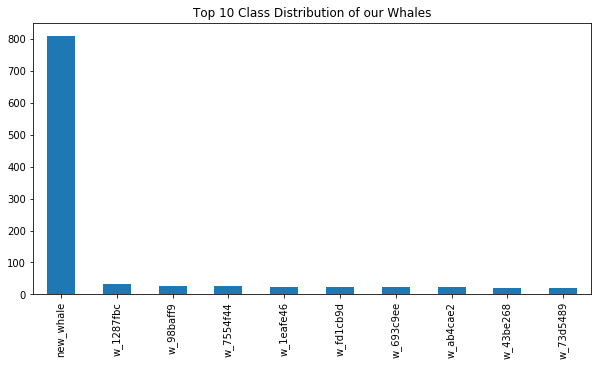

In [8]:
train_csv.Id.value_counts().head(10).plot.bar(title='Top 10 Class Distribution of our Whales'
                                             , figsize= (10,5))

There's some major class imbalance, as we can see "new_whale" far outnumbers there rest of the IDs.
Let's first remove the new_whale class that is causing the major imbalance, and then see the distribution of the rest of our classes

In [9]:
images_remove = train_csv[train_csv['Id'] == 'new_whale']['Image'].reset_index(drop=True)


In [10]:
train_csv = train_csv[train_csv['Id'] != 'new_whale']
train_csv.Id.value_counts().head()


w_1287fbc    34
w_98baff9    27
w_7554f44    26
w_1eafe46    23
w_fd1cb9d    22
Name: Id, dtype: int64

In [11]:
train_csv.reset_index(drop=True, inplace=True)

In [12]:
train_csv.Id.value_counts().head(100).plot.bar(title='Top 10 Class Distribution of our Whales after removing New Whale Class'
                                             , figsize= (10,5))

In [13]:
print("There are now", train_csv.Id.nunique(), "classes")

There are now 4250 classes


**Let's have a look at our datset**

In [14]:
import os
#train_dir = "../input/humpback-whale-identification/train" #train.zip file directory
test_dir = "../data/test/test" #test.zip file directory
#train_list = ["../input/humpback-whale-identification/train/{}".format(i) for i in os.listdir(train_dir)] #Retrieve all train images
test_list = ["../data/test/test/{}".format(i) for i in os.listdir(test_dir)] #Retrieve all test images

#del train_dir #clear lists that are no longer of use
#del test_dir
#gc.collect() #collect garbage to save memory

Shuffle the dataset randomly
So that the dev and test set have the same distribution

In [15]:
#random.shuffle(train_csv) #
train_csv = train_csv.sample(frac=1) # lookup. 


In [16]:
train_list =[]
for i in range(len(train_csv)):
    train_list.append("../data/train/train/" + train_csv['Image'][i])
    
    

In [17]:
print("We have ", len(train_list), "examples")

We have  9040 examples


Let's have a look at some of our Whale Pictures!

In [18]:
import mpimg
for img in train_list[:5]:
    img = mpimg.imread(img)
    image_plot = plt.imshow(img)
    plt.show()


ImportError: No module named 'mpimg'

**Data Pre-processing**

Let's create some custom function to pre-process our images.
We will use OpenCV to read and resize our images.

We will be using the following dimensions for our images  (m, 224, 224, 3). 

In [19]:
def preprocess_whale(image_paths):
    """A function to preprocess image dataset.
    By resizing the images and turning them into arrays
    
    Parameters:
    m: int
        The training set size
    image_paths: string
        A string with the image paths of the dataset
        
    Returns:
    A 2D Numpy array
    """
    #X = np.zeros((m,100,100,3))
    #index = 0
    #for path in image_paths:
        #img = image.load_img(path, target_size=(100,100,3))
        #x = image.img_to_array(img)
        #x = preprocess_input(x)
    
    X= []
    for image in image_paths:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), # not black and white,
                                      (224,224), interpolation= cv2.INTER_CUBIC)) #use 224, 224, 3 Dimensions 
    
    
    #Initialize inpiut with zeros of desires dimensions
    #X[index] = x
    #index =+ 1
           
    return X


### Y labels

In [20]:
train_id_list =[]
for i in range(len(train_csv)):
    train_id_list.append(train_csv['Id'][i])

In [21]:
#Y_train = encode_labels(train_id_list)

In [22]:
#df_encoded = joblib.load("../data/df_encoded.pkl")
#Y_train = joblib.load('../data/Y_train.pkl')

In [23]:
Y_train.shape

(5876, 4250)

In [24]:
Y_holdout.shape

(3164, 4250)

In [25]:
X_train.shape

(5876, 224, 224, 3)

In [26]:
X_holdout.shape

(3164, 224, 224, 3)

In [ ]:

#import joblib#joblib.dump(df_encoded, "../data/df_encoded.pkl")
#joblib.dump(Y_train, '../data/Y_train.pkl')

The column value of the Shape of our Y_train array should be 4250 as there are that many classes, Let's check

In [ ]:

X_train = preprocess_whale(train_list )

In [ ]:
import numpy as np
X_train = np.asarray(X_train) /255

In [ ]:
import gc
gc.collect()

#### Check your dimensions

In [ ]:
X_train.shape

In [ ]:
X_holdout.shape

In [ ]:
joblib.dump(X_train, '../data/X_train.pkl')

In [ ]:
#import pickle
# Save the best result
#be_result=be.predict(test_filtered_scaled)
# Save the model
#pickle.dump(X_train, open('../data/X_train.pkl', 'wb'))



In [ ]:
# some time later...
 
# load the model from disk
#X_train = joblib.load(open('../data/X_train.npy', 'rb'))


In [ ]:
#X_submit = preprocess_whale(test_list)
#joblib.dump(X_submit, '../input/X_submit.pkl')

In [ ]:
#gc.collect()

In [27]:
import numpy as np
#Normalize the inputs in order to let our cost function optimize faster and to scale our Data
X_train = X_train/ 255
#X_submit = np.array(X_submit) / 255

In [ ]:
print(X_train.shape)
print(Y_train.shape)

#print(X_submit.shape)

[](http://)Let's build our ConvNet! I will be using Keras for this model. (Tensorflow perhaps later to upskill)

In [ ]:
train_csv.reset_index(drop=True, inplace=True)

In [ ]:
train_csv.head()

Split our Data into a Train, Dev and Test
We will train on our Train Data, evaluate and tune the model using Cross Validation and then finally Test on our Hold-out Data (Test Data) which is a 35% split.  

Include a random shuffle before splitting the data (done earlier)

In [ ]:
X_train_set = train_csv['Image'][:5876]
Y_train_set = train_csv['Id'][:5876]
#X_dev_set = X_train[6840:7940]
#Y_dev_set = Y_train[6840:7940]
X_holdout_set = train_csv['Image'][5876:]
Y_holdout_set = train_csv['Id'][5876:]


In [ ]:
X_train.shape

In [ ]:
Y_train.shape

In [ ]:
Y_holdout.shape

In [ ]:
X_holdout.shape


To get started with our ConvNet, it's useful to look at the shapes of our dataset


In [ ]:
print ("number of training examples = " + str(X_train_set.shape[0]))
print ("number of holdout set examples = " + str(X_holdout_set.shape[0]))
print ("X_train shape: " + str(X_train_set.shape))
print ("Y_train shape: " + str(Y_train_set.shape))
print ( "X_holdout_set" + str(X_holdout_set.shape))
print ("Y_holdout_set" + str(Y_holdout_set.shape))

In [ ]:
X_train_set.reset_index(inplace=True, drop=True)
Y_train_set.reset_index(inplace=True, drop=True)
X_holdout_set.reset_index(inplace=True, drop=True)
Y_holdout_set.reset_index(inplace=True, drop=True)

In [ ]:
X_train_list =[]
for i in range(len(X_train_set)):
    X_train_list.append( X_train_set[i])

X_train_list[:10]

In [ ]:
len(X_train_list)

In [ ]:
Y_train_list =[]
for i in range(len(Y_train_set)):
    Y_train_list.append( Y_train_set[i])
Y_train_list[:10]

In [ ]:
len(Y_train_list)

In [ ]:
X_holdout_list =[]
for i in range(len(X_holdout_set)):
    X_holdout_list.append( X_holdout_set[i])
X_holdout_list[:10]

In [ ]:
len(X_holdout_list)

In [ ]:
Y_holdout_list =[]
for i in range(len(Y_holdout_set)):
    Y_holdout_list.append( Y_holdout_set[i])
Y_holdout_list[:10]

In [ ]:
len(Y_holdout_list)

In [ ]:
def generate_data(directory, batch_size):
    """Replaces Keras' native ImageDataGenerator."""
    i = 0
    file_list = os.listdir(directory)
    while True:
        image_batch = []
        for b in range(batch_size):
            if i == len(file_list):
                i = 0
                random.shuffle(file_list)
            sample = file_list[i]
            i += 1
            image = cv2.resize(cv2.imread(sample[0]), INPUT_SHAPE)
            image_batch.append((image.astype(float) - 128) / 128)

        yield np.array(image_batch)

In [28]:
def model_convnet(layers= 1025 , dropout=0.8, activation=None, optimizor= 'Adam', learn_rate=0.01):
    model = Sequential()

    model.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (224, 224, 3)))

    model.add(BatchNormalization(axis = 3, name = 'bn0'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), name='max_pool'))
    model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
    model.add(Activation('relu'))
    model.add(AveragePooling2D((3, 3), name='avg_pool'))

    model.add(Flatten())
    model.add(Dense(layers, activation="relu", name='rl'))
    model.add(Dropout(dropout))
    model.add(Dense(4250, activation='softmax', name='sm'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizor, metrics=['accuracy'])
    print(model.summary())
    
    return model

In [ ]:
import numpy as np

from keras.models import Sequential
from my_classes import DataGenerator

# Parameters
params = {'dim': (224, 224),
          'batch_size': 40,
          'n_classes': 4250,
          'n_channels': 3,
          'shuffle': True}

# Datasets
# Datasets
partition = {}
partition['train'] = X_train_list
partition['validation'] = X_holdout_list

X_whole = X_train_list + X_holdout_list
Y_whole = Y_train_list + Y_holdout_list
labels =  dict(zip(X_whole, Y_whole))
# Sanity check
train_csv[train_csv['Image']=='d08b2149.jpg']
print(labels['d08b2149.jpg'])


# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

# Design model
model_convnet

# Train model on dataset
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=6)

In [ ]:
conv_model = model_convnet().fit(X_train, Y_train, epochs = 20, batch_size = 40, 
          validation_data=(X_holdout, Y_holdout), verbose=1)


In [ ]:
joblib.dump(model_convnet, '../data/conv_net_model.pkl')

In [ ]:
# summarize history for accuracy
plt.plot(trainer.history['acc'])
plt.plot(trainer.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Change model distribution. For Dev and Test. Radomize train , put X and y in one Dataframe and shuffle, then train

Grid Search to help tune hyperparameters and fix overfitting. (Takes extremely long, haven't done yet)

In [ ]:
# create model
model = KerasClassifier(build_fn = model_convnet, epochs =100, batch_size= 32, verbose=1)

# define the grid search parameters
#batch_size = [16, 32, 64] doesn't eally 
#layers = [10, 100, 300, 500]
dropout = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]

param_grid = dict(#layers=layers,
                  dropout=dropout, 
                  learn_rate=learn_rate)

# search the grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid,
                    cv=5,
                    verbose=1)  # include n_jobs=-1 if you are using CPU

grid_result = grid.fit(X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 218, 218, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 218, 218, 32)      128       
_________________________________________________________________
activation_3 (Activation)    (None, 218, 218, 32)      0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 109, 109, 32)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 107, 107, 64)      18496     
_________________________________________________________________
activation_4 (Activation)    (None, 107, 107, 64)      0         
_________________________________________________________________
avg_pool (AveragePooling2D)  (None, 35, 35, 64)       

W0805 12:55:49.100375 140468209059584 deprecation.py:323] From /mnt/c/Users/Tshankzd/Desktop/computer-vision/compvis_env/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
4700/4700 [==============================] - 1544s 329ms/step - loss: 11.8663 - acc: 6.3830e-04
Epoch 2/100
4700/4700 [==============================] - 1421s 302ms/step - loss: 8.1847 - acc: 0.0034
Epoch 3/100
3712/4700 [======================>.......] - ETA: 5:13 - loss: 7.7231 - acc: 0.0078

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
joblib.dump(grid_results, "../input/Grid_search.pkl")

In [ ]:
gc.collect()

Our Grid Search is proving to be computationally expensive, a random search could be tried but to try bypass the overfitting, a new model arcgitecture will have to be chosen

In comes VGG-16 pretrained model

In [ ]:
from keras.applications.vgg16 import VGG16
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print(vgg_conv.summary())

## What is my model doing exactly??
### Visualize feature maps output from each block in the vgg model

We can see that the feature maps closer to the input of the model capture a lot of fine detail in the image and that as we progress deeper into the model, the feature maps show less and less detail.

This pattern was to be expected, as the model abstracts the features from the image into more general concepts that can be used to make a classification. Although it is not clear from the final image that the model saw a whale, we generally lose the ability to interpret these deeper feature maps.

In [ ]:
# load the model
model = vgg_conv
# redefine model to output right after the first hidden layer
# Tske the last layes of each conv block i.e the max_pooling layers. 
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
img = load_img('test_pic_viz.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    pyplot.show()

In [ ]:
# Freeze the layers except the last 1 layers
for layer in vgg_conv.layers[:-1]:
    layer.trainable = False
    
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

In [ ]:
def vgg_unfreeze(vgg_conv=vgg_conv):
    """
    Takes the final max-pooling layer of the vgg-16 model"""
    # Create the model
    model = models.Sequential()

    # Add the vgg convolutional base model
    model.add(vgg_conv)

    # Add new layers
    model.add(layers.Flatten())
    #model.add(layers.Dense(1024, activation='relu'))
    #model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4250, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    # Show a summary of the model. Check the number of trainable parameters
    return model


In [ ]:
print(vgg_unfreeze().summary())


unfreeze dense layers to get right amount of predictions

In [ ]:
vgg = vgg_unfreeze().fit(X_train, Y_train, epochs = 100, batch_size = 32, 
          validation_data=(X_holdout, Y_holdout), verbose=1)

Training accuracy starts off lower than validation accuracy - the final dropout layer in the model could be the reason. 

### Why is the training loss much higher than the testing loss?
A Keras model has two modes: training and testing. Regularization mechanisms, such as Dropout and L1/L2 weight regularization, are turned off at testing time.

Besides, the training loss is the average of the losses over each batch of training data. Because your model is changing over time, the loss over the first batches of an epoch is generally higher than over the last batches. On the other hand, the testing loss for an epoch is computed using the model as it is at the end of the epoch, resulting in a lower loss.
-  credit: FAQ Keras Documentaion



In [ ]:
# summarize history for accuracy
plt.plot(vgg.history['acc'])
plt.plot(vgg.history['val_acc'])
plt.title('model accuracy VGG-16 last maxpool layer - Transfer')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

In [ ]:
joblib.dump(vgg, "../data/vgg16_lastmax.pkl")

 Read up on generators and fit generate (this is the disk memory stuff, so that the model doesn't crash